In [1]:
from graph_tool.all import *
from numba import jit
from numba.types import int64
from numba import njit, prange
from numba import jit, njit
from numba.types import float64, int64
from numba import njit, prange
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-qqwmfngv because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
## FUNCTIONS

def filter_by_location(np_array):
    
    # Sort input array test w.r.t. first column that are IDs
    test_sorted = np_array[np_array[:,1].argsort()]

    # Convert the string IDs to numeric IDs
    locations = np.unique(test_sorted[:,1], return_inverse=False)
    # print('shape of numeric_ID {}'.format(numeric_ID.shape))

    # Get the indices where shifts (IDs change) occur
    _,cut_idx = np.unique(test_sorted[:,1],return_index=True)

    # Use the indices to split the input array into sub-arrays with common IDs
    return np.split(test_sorted,cut_idx)[1:]

@njit
def get_contact_per_location(test_case, parameters, w=None, purpose=None, locsize=10):
    
    # ID - LOCATION - START TIME - END TIME / PURPOSE
    
    edge_list=[]
    #threshold=.012550110735619152
    #w=6.95002417897531
    #threshold=w/(w+locsize-2)
    #threshold=0.012550110735619152
    #act=np.array([[0,  5,  6,  8,  11],
    #               [5,  1,  7,  9,  12],
    #               [6,  7,  2, 10,  13],
    #               [8,  9, 10,  3,  14],
    #               [11,12, 13, 14,   4]])
    
    
    act=np.array([[0,  3,  4],
                  [3,  1,  5],
                  [4,  5,  2]])

    
    #threshold=np.array([[0.00612023, 0.02394995, 0.20427608],
    #   [0.02394995, 0.02013064, 0.        ],
    #   [0.20427608, 0.        , 0.10465638]])
    
    #threshold=0.02
        
    for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
        row=test_case[i]
        pu=purpose[i] # origin
        
        rem=test_case[(i+1):]
        
        for k, pv in zip(rem, purpose[(i+1):]):  
            if k[0]!=row[0]: # if individuals are different
                
                if row[-1]<=k[2]: # no intersection
                    break
                
                
                if pu>1:
                    pu=2
                
                if pv>1:
                    pv=2
                
                
                if w!=None:
                    threshold=w[pu,pv]/(w[pu,pv]+locsize-2)
                else:
                    threshold=parameters[pu, pv]
                    
                if np.random.uniform(0,1,1)[0]<=threshold:
                #if np.random.uniform(0,1,1)[0]<=threshold[pu,pv]:
                    if row[-1]<k[-1]:
                        d=row[-1]-k[2]
                        #edge_list.append((row[0], k[0], d, act[pu, pv], row[1]))
                    else:
                        d=k[-1]-k[2]
                        
                    edge_list.append((row[0], k[0], d, act[pu, pv], row[1]))

    return edge_list

@njit
def get_properties_potential_contact_network(test_case, purpose=None):
    
    # ID - LOCATION - START TIME - END TIME / PURPOSE
     
    act=np.zeros((3, 3))
    number_of_contacts_per_location=0
        
    for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
        row=test_case[i]
        pu=purpose[i] # origin
        
        rem=test_case[(i+1):]
        
        for k, pv in zip(rem, purpose[(i+1):]):  
            if k[0]!=row[0]: # if individuals are different
                
                if row[-1]<=k[2]: # no intersection
                    break
                else:
                    if pu>2:
                        pu=2
                
                    if pv>2:
                        pv=2
                    act[pu, pv]+=1
                    number_of_contacts_per_location+=1

    return act, number_of_contacts_per_location

# This function helps me to check which agent is involved in a layer, and the number of occurences. This will be useful to compute the expected value of contacts by layer

@njit
def get_status(n, out):
    status_layer=np.zeros((n, 5))
    for k in out:
        for l in k:
            status_layer[l[0],l[-1]]+=1
    return status_layer




def get_contacts_fast_2(G, attr1=None):
    e=G.get_edges()
    v=G.get_vertices(vprops=[G.vp['age']])

    acp=np.vstack((v[e[:,0],1],v[e[:,1],1])).T
    #twins=acp[acp[:,0]==acp[:,1]]
    #others=acp[acp[:,0]!=acp[:,1]]

    
    #return np.vstack((twins,others,others[:,[1,0]]))
    return acp

In [3]:
## DATA PRE-PROCESSING

#df_persons=pd.read_csv('data/all/egt/persons.csv',';').drop(['Unnamed: 0'], axis=1)

df_persons=pd.read_csv('raw-updated/persons.csv',',')
df_persons['person_id_gt']=df_persons.index

df_homes=pd.read_csv('raw-updated/homes.csv')
df_persons=pd.merge(df_persons, df_homes, left_on='household_id', right_on='hid', how='outer')

In [4]:
df_persons.head()

,person_id,household_id,age,employed,sex,socioprofessional_class,has_driving_license,has_pt_subscription,census_person_id,hts_id,person_id_gt,hid,hinsee,hzone
0,0,0,67,False,male,7,False,True,0,14773,0,0.0,75119.0,991445.0
1,691,372,66,False,male,7,False,True,274,14773,1,372.0,75119.0,916602.0
2,692,372,66,False,male,7,True,False,274,31547,2,372.0,75119.0,916602.0
3,3528,1961,66,False,male,7,False,True,1452,14773,3,1961.0,75118.0,872169.0
4,3525,1961,66,False,male,7,False,True,1452,22340,4,1961.0,75118.0,872169.0


In [4]:
from itertools import combinations

list_of_contacts_in_HH=[]

with tqdm(total=len(df_persons['household_id'].unique()), position=0, leave=True) as pbar: 
    for k in df_persons[['household_id','person_id_gt']].groupby('household_id'):
        if k[1].shape[0]>1:
            list_of_contacts_in_HH.extend(list(combinations(k[1]['person_id_gt'], 2)))
        
        pbar.update(1)
    

100%|██████████| 5226178/5226178 [06:25<00:00, 13543.10it/s]


In [6]:
len(list_of_contacts_in_HH)

12388655

In [7]:
#df_activities=pd.read_csv('raw-updated/activities.csv').drop(['Unnamed: 0'], axis=1).rename(columns={'uid':'location_id'})

df_activities=pd.read_csv('raw-updated/activities.csv').rename(columns={'uid':'location_id'})
df_activities=df_activities[df_activities['purpose']!='home']
df_activities=df_activities[(~df_activities.start_time.isnull())&(~df_activities.end_time.isnull())]
df_activities['purpose']=df_activities['purpose'].astype('category').cat.reorder_categories(['work', 'education', 'leisure', 'shop', 'other']).cat.codes
df_activities=df_activities.merge(df_persons[['person_id_gt', 'person_id','age']], on='person_id') 

In [18]:
df_activities[df_activities['age']>25].purpose.value_counts()

0    5927206
4    4916355
2    4503761
3    4279998
1     116693
Name: purpose, dtype: int64

In [8]:
## SPATIAL CLUSTERING OF INDIVIDUALS

#mapping=df_persons[['person_id','person_id_gt']].set_index('person_id').to_dict()['person_id_gt']

out=filter_by_location(df_activities[['person_id_gt','location_id','start_time','end_time','purpose']].astype(int).values)

In [9]:
out[0]

array([[4416540,      30,   37559,   46559,       0],
       [4039169,      30,   25938,   58158,       0],
       [2066449,      30,   47090,   54290,       0],
       [2066449,      30,   27410,   38090,       0],
       [4416543,      30,   29025,   64425,       0],
       [4039168,      30,   24784,   57004,       0],
       [1766826,      30,   32175,   61275,       0],
       [2186512,      30,   29197,   60397,       0],
       [2066449,      30,   58010,   66890,       0],
       [3826288,      30,   30488,   59288,       0]])

In [10]:
## NUMBER OF INVOLVED INDIVIDUALS / LAYER

status_layer=get_status(df_persons.shape[0], out)
number_of_agents_by_layer=np.count_nonzero(status_layer, axis=0)
number_of_agents_by_layer

/usr/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'out' of function 'get_status'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-2-7ee05ec088c0>", line 116:
@njit
def get_status(n, out):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


array([4145154, 2013147, 4088141, 3644940, 3354576])

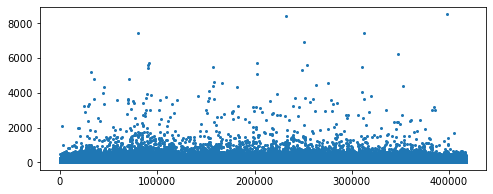

In [11]:
## SPATIAL DISTRIBUTION OF LOCATION SIZES

a,b=np.unique([np.unique(group[:,0]).shape[0] for group in out], return_counts=True)

fig, ax=plt.subplots(figsize=(2*4,3))
ax.plot([np.unique(group[:,0]).shape[0] for group in out], 'o', ms=2.)
plt.show()

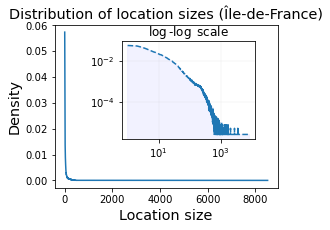

In [12]:
u, c=np.unique([np.unique(group[:,0]).shape[0] for group in out], return_counts=True)

fig, ax=plt.subplots(figsize=(4,3))
ax.plot(u,c/c.sum())
ax.set_xlabel('Location size', fontsize='x-large')
ax.set_ylabel('Density', fontsize='x-large')
#ax.grid(True, lw=0.1)
ax.set_title('Distribution of location sizes (Île-de-France)', fontsize='x-large')


#ax.set_xticks(u)
#ax.set_xticklabels(u,fontsize='x-large')

# inset axes....
axins = ax.inset_axes([0.3, 0.3, 0.6, 0.6])
axins.loglog(u,c/c.sum(),'--')
axins.grid(True, lw=0.1)
#ax.set_xlabel('Location size', fontsize='x-large')
#ax.set_ylabel('Density', fontsize='x-large')
axins.set_title(r'$\log$-$\log$ scale')

axins.fill_between(u, c/c.sum(), 0,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.1/2)          # Transparency of the fill



#x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])
#ax.indicate_inset_zoom(axins, edgecolor="black")
#fig.savefig('dls.pdf', bbox_inches='tight')
#fig.savefig('dls.jpg', bbox_inches='tight', dpi=400)
plt.show()

In [13]:
## PROPERTIES OF THE POTENTIAL CONTACT NETWORK

list_of_group_contacts=[] # To store the amount of contacts generated after filtering per space/time at location ID k
list_of_adjacency_matrices=[]
nbloc=0

sttm=time.time()

loop_over=out

with tqdm(total=len(loop_over), position=0, leave=True) as pbar: 
    for k in loop_over:
        locsize=len(np.unique(k[:,0]))
        if locsize>1:
            k_sorted=k[k[:, 2].argsort()]
            fo, nb_cnts=get_properties_potential_contact_network(k_sorted[:,0:-1], k_sorted[:,-1])
            list_of_group_contacts.append((locsize, nb_cnts))
            list_of_adjacency_matrices.append(fo)
            nbloc+=1
        pbar.update(1)
        
print(time.time()-sttm)

100%|██████████| 417089/417089 [01:03<00:00, 6613.07it/s] 

63.07375645637512


In [14]:
list_of_adjacency_matrices

[array([[39.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]),
 array([[   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0., 3987.]]),
 array([[181.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]),
 array([[16.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]),
 array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0., 56.]]),
 array([[60.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]),
 array([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0., 603.]]),
 array([[   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0., 1166.]]),
 array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0., 49.]]),
 array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0., 41.]]),
 array([[   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0., 1129.]]),
 array([[   0.,    0.,    0.],
        [   0., 2089., 1440.],
        [   0.,  25

59840287


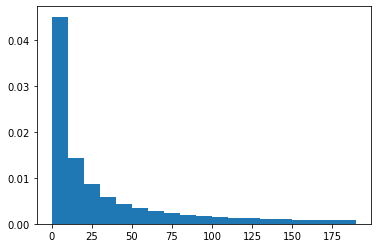

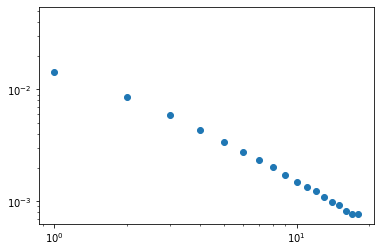

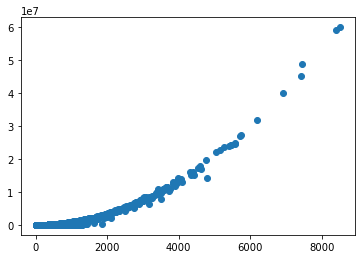

In [15]:
plt.figure()
pp1=plt.hist([k[1] for k in list_of_group_contacts], np.arange(20)*10, density=True)
#plt.axvline(x=max([k[1] for k in list_of_group_contacts]))
print(max([k[1] for k in list_of_group_contacts]))

plt.figure()
plt.loglog(pp1[0], 'o')

plt.figure()
plt.scatter([k[0] for k in list_of_group_contacts], [k[1] for k in list_of_group_contacts])
plt.show()

In [15]:
#np.triu(E*parameters, k=0)

In [16]:
# AGGREGATE

overall_potential_network=np.zeros((3, 3))

for k in list_of_adjacency_matrices:
    overall_potential_network=overall_potential_network+k

#(overall_potential_network>0).astype(int)

# purpose_network=Graph(directed=True)
# purpose_network.add_edge_list(np.transpose((overall_potential_network>0).astype(int).nonzero()))
# purpose_network.ep['w'] = purpose_network.new_ep('int', vals=overall_potential_network.reshape((-1,)))

In [14]:
# np.tril(overall_potential_network, k=-1).T+np.triu(overall_potential_network, k=0)

In [15]:
#(np.tril(overall_potential_network, k=-1).T+np.triu(overall_potential_network, k=0))[:3,2:].sum(axis=1)

In [17]:
def aggregate(A, n):
    B=np.zeros((n,n))
    #B[0:(n-1),0:(n-1)]=(np.tril(A, k=-1).T+np.triu(A, k=0))[0:(n-1),0:(n-1)]
    #B[(n-1),(n-1)]=(np.tril(A, k=-1).T+np.triu(A, k=0))[(n-1):,(n-1):].sum()
    #B[:,(n-1)]=(np.tril(A, k=-1).T+np.triu(A, k=0))[:n,(n-1):].sum(axis=1)
    
    B[:(n-1),:(n-1)]=A[:(n-1),:(n-1)]
    B[(n-1),(n-1)]=A[(n-1):,(n-1):].sum()
    B[(n-1),:(n-1)]=A[(n-1):,:(n-1)].sum(axis=0)
    B[:(n-1),(n-1)]=A[:(n-1),(n-1):].sum(axis=1)
    
    return np.tril(B, k=-1).T+np.triu(B, k=0)
    

In [18]:
print(overall_potential_network)
E=aggregate(overall_potential_network, 3)
print(E)

[[2.56961632e+09 9.99064400e+06 1.25749890e+07]
 [1.38992340e+07 3.72462024e+08 4.53532620e+07]
 [1.15564500e+06 3.10942700e+06 2.25253147e+08]]
[[2.56961632e+09 2.38898780e+07 1.37306340e+07]
 [0.00000000e+00 3.72462024e+08 4.84626890e+07]
 [0.00000000e+00 0.00000000e+00 2.25253147e+08]]


In [29]:
E

array([[2.56961632e+09, 2.38898780e+07, 1.37306340e+07],
       [0.00000000e+00, 3.72462024e+08, 4.84626890e+07],
       [0.00000000e+00, 0.00000000e+00, 2.25253147e+08]])

In [30]:
E.sum()

3253414690.0

In [34]:
df_persons.head()

,person_id,household_id,age,employed,sex,socioprofessional_class,has_driving_license,has_pt_subscription,census_person_id,hts_id,person_id_gt
0,0,0,67,False,male,7,False,True,0,14773,0
1,691,372,66,False,male,7,False,True,274,14773,1
2,692,372,66,False,male,7,True,False,274,31547,2
3,3528,1961,66,False,male,7,False,True,1452,14773,3
4,3525,1961,66,False,male,7,False,True,1452,22340,4


In [44]:
df_persons.head()

,person_id,household_id,age,employed,sex,socioprofessional_class,has_driving_license,has_pt_subscription,census_person_id,hts_id,person_id_gt,hid,hinsee,hzone
0,0,0,67,False,male,7,False,True,0,14773,0,0.0,75119.0,991445.0
1,691,372,66,False,male,7,False,True,274,14773,1,372.0,75119.0,916602.0
2,692,372,66,False,male,7,True,False,274,31547,2,372.0,75119.0,916602.0
3,3528,1961,66,False,male,7,False,True,1452,14773,3,1961.0,75118.0,872169.0
4,3525,1961,66,False,male,7,False,True,1452,22340,4,1961.0,75118.0,872169.0


In [19]:
# COMBINING HOUSEHOLD AND NON-HOUSEHOLD CONTACTS
# Add household-based contacts !

#graph_household=load_graph('files/graph_weekday_household_all.xml.gz')

graph_household=Graph(directed=False)
graph_household.add_vertex(df_persons.shape[0])

graph_household.vp['age'] = graph_household.new_vp('int', vals=df_persons.age.values.astype(int), val=None)
# graph_household.vp['dep'] = graph_household.new_vp('int', vals=df_persons.numdep.values.astype(int), val=None)
graph_household.vp['insee'] = graph_household.new_vp('int', vals=df_persons.hinsee.values.astype(int), val=None)

graph_household.add_edge_list(list_of_contacts_in_HH)

graph_household.edge_properties['p'] = graph_household.new_ep('int', vals=None, val=10000000)
graph_household.edge_properties['purpose'] = graph_household.new_ep('int', vals=None, val=6)
graph_household.edge_properties['duration'] = graph_household.new_ep('int', vals=None, val=24*60)

In [20]:
print('Average contact rate in HH layer =',graph_household.num_edges()*2/graph_household.num_vertices())

Average contact rate in HH layer = 2.10718934037643


In [21]:
# Calcul de p_EE


mu_HH=graph_household.num_edges()*2/graph_household.num_vertices()
mu_EE=1.55*mu_HH*2.5
#mu_WW=3.17*2.11
mu_WW=3.17*mu_HH

#pi_EE=0.97
pi_EE=0.97 # socio-patterns

p_EE=(pi_EE*mu_EE*number_of_agents_by_layer[1])/(2*E[1,1])
p_EE

p_EW=((1-pi_EE)*mu_EE*number_of_agents_by_layer[1])/E[0,1]
p_EW

p_EX=0 # by assumption

# pi_WW=0.9 because by averaging all the pi_WW_j where j is individual j

p_WW=(.9*mu_WW*number_of_agents_by_layer[0])/(2*E[0,0])
p_WW

p_WX=(mu_WW*number_of_agents_by_layer[0]-2*E[0,0]*p_WW-E[0,1]*p_EW)/E[0,2]
p_WX


# daily average number of contacts is 10 by assumption
#(10*graph_household.num_vertices()/2-graph_household.num_edges())/E.sum()
p0=(10*df_persons.shape[0]/2-len(list_of_contacts_in_HH))/E.sum()


# by using the general equation
p_XX=(p0*E.sum()
      -E[0,0]*p_WW
      -E[1,1]*p_EE
      -E[0,1]*p_EW
      -E[0,2]*p_WX
      -E[1,2]*p_EX)/E[2,2]
p_XX

parameters=np.array([[p_WW, p_EW, p_WX],
          [p_EW, p_EE, p_EX],
          [p_WX, p_EX, p_XX]])

print(parameters>=0)
print(parameters<=1)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [22]:
# optimal values of w

from scipy import optimize

def f(x, list_of_adjacency_matrices, list_of_group_contacts, E, parameters, row, col): # args: list_of_adjacency_matrices, list_of_group_contacts, E, parameters
    lhe=0
    for i, j in zip(list_of_adjacency_matrices, list_of_group_contacts):
        if row==col:
            lhe+=i[row,col]*x/(x+j[0]-2)
        else:    
            lhe+=sum([i[row,col], i[col,row]])*x/(x+j[0]-2)
    
    return lhe-np.triu(E*parameters, k=0)[row,col]

def f_exp(x, list_of_adjacency_matrices, list_of_group_contacts, E, parameters, row, col): # args: list_of_adjacency_matrices, list_of_group_contacts, E, parameters
    lhe=0
    for i, j in zip(list_of_adjacency_matrices, list_of_group_contacts):
        if row==col:
            lhe+=i[row,col]*np.exp(-x*(j[0]-2))
        else:    
            lhe+=sum([i[row,col], i[col,row]])*np.exp(-x*(j[0]-2))
    
    return lhe-np.triu(E*parameters, k=0)[row,col]


n=3
w=np.zeros((n,n))


with tqdm(total=n*n-n*(n-1)/2, position=0, leave=True) as pbar: 
    for row in range(n):
        for col in range(row,n):
            if np.triu(E*parameters, k=0)[row,col]>0:
                sols=optimize.root_scalar(f, args=(list_of_adjacency_matrices, list_of_group_contacts, E, parameters, row, col), bracket=[1/500, 200], method='brentq')
                w[row, col]=np.round(sols.root,4)
            pbar.update(1)
            
w=np.triu(w,k=1).T+w
w

100%|██████████| 6/6.0 [00:10<00:00,  1.78s/it]


array([[ 3.9569, 21.1877, 83.0187],
       [21.1877,  6.571 ,  0.    ],
       [83.0187,  0.    , 26.7077]])

In [23]:
# wt=3.8429
# x=np.arange(8000)+2
# x=np.asarray([k[0] for k in list_of_group_contacts])
# y=1/(wt+x-2)*wt

# wa=0.0313
# y1=np.exp(-wa*(x-2))
# #plt.plot(x, y, label='dflt')
# #plt.plot(x, y1, label='exp')

# plt.axhline(y=parameters[0,0], ls='--', lw=0.5, color='red',label='no effects')
# plt.axhline(y=y.mean(), ls='--', lw=0.5, color='blue',label='avg of dflt')
# plt.axhline(y=y1.mean() , ls='--', lw=0.5, color='orange',label='avg of exp')

# #plt.xlim(150, 300)
# #plt.ylim(0,0.0075)
# plt.xlabel('location size')
# plt.ylabel('p')
# plt.legend()

In [24]:
#list_of_group_contacts=[] # To store the amount of contacts generated after filtering per space/time at location ID k
list_of_contacts=[]

sttm=time.time()

loop_over=out

with tqdm(total=len(loop_over), position=0, leave=True) as pbar: 
    for k in loop_over:
        if k.shape[0]>1:
            k_sorted=k[k[:, 2].argsort()]
            fo=get_contact_per_location(k_sorted[:,0:-1], parameters, w, k_sorted[:,-1], len(np.unique(k_sorted[:,0])))
            #list_of_group_contacts.append((len(np.unique(k_sorted[:,0])), len(fo))) # n_ij and E_ij
            list_of_contacts.extend(fo)
        pbar.update(1)
        
print(time.time()-sttm)

100%|██████████| 417089/417089 [06:48<00:00, 1020.06it/s]

408.88800024986267


In [25]:
## BUILD PHYSICAL CONTACT NETWORK
# Here I build my contact network based on the list of edges previously computed

print('Creating an undirected contact network of size ', df_persons.shape[0], ' nodes ...')

start_time=time.time()

setting_temporal_network=Graph(directed=False)
setting_temporal_network.add_vertex(df_persons.shape[0])

setting_temporal_network.vp['age'] = setting_temporal_network.new_vp('int', vals=df_persons.age.values.astype(int), val=None)
#setting_temporal_network.vp['dep'] = setting_temporal_network.new_vp('int', vals=df_persons.numdep.values.astype(int), val=None)
setting_temporal_network.vp['insee'] = setting_temporal_network.new_vp('int', vals=df_persons.hinsee.values.astype(int), val=None)

ppid = setting_temporal_network.new_ep('int')
purpose = setting_temporal_network.new_ep('int')
dur = setting_temporal_network.new_ep('int')

#ppis = setting_temporal_network.new_ep('int')

setting_temporal_network.edge_properties['duration'] = dur
setting_temporal_network.edge_properties['purpose'] = purpose
setting_temporal_network.edge_properties['p'] = ppid

#setting_temporal_network.edge_properties['n'] = ppis

print('Adding links ...')
setting_temporal_network.add_edge_list(list_of_contacts, eprops=[dur, purpose, ppid])

print('contact network has {} egdes and {} vertices'.format(setting_temporal_network.num_edges(), setting_temporal_network.num_vertices()))
print('Setting-based contact network estimated in ',time.time()-start_time, ' secs !')

# setting_temporal_network.save("files/graph_weekday_complete.xml.gz")

Creating an undirected contact network of size  11758464  nodes ...
Adding links ...
contact network has 46398041 egdes and 11758464 vertices
Setting-based contact network estimated in  110.07153296470642  secs !


In [26]:
print('okok')

setting_temporal_network.add_edge_list(graph_household.get_edges([graph_household.ep['duration'], graph_household.ep['purpose'], graph_household.ep['p']]), 
                                       eprops=[dur, purpose, ppid])

print('graph loaded !')
print('graph estimation completed !')

okok
graph loaded !
graph estimation completed !


In [27]:
print('Average contact rate in overall layer =', setting_temporal_network.num_edges()*2/setting_temporal_network.num_vertices())

Average contact rate in overall layer = 9.999043412472922


In [5]:
# Load graph

# setting_temporal_network=load_graph('files/graphs/contact_network2.xml.gz')

In [36]:
at=graph_household.get_edges([graph_household.ep['duration'], graph_household.ep['purpose'], graph_household.ep['p']]).T
ll=list(zip(at[0],at[1], at[2], at[3], at[4]))

In [37]:
# To load the graph
# setting_temporal_network = load_graph("files/graphs/contact_network2.xml.gz")

[0 1 2 3 4 6] [12208080  7938237 23530004   491692  2221651 12388619]


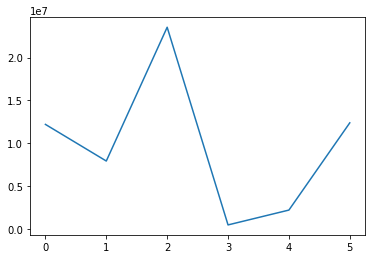

In [38]:
un, cn=np.unique(setting_temporal_network.ep['purpose'].a, return_counts=True)
print(un, cn)
plt.plot(cn)

In [39]:
# setting_temporal_network.add_edge_list(graph_household.get_edges(eprops=[graph_household.ep['p'], graph_household.ep['purpose']]))

(array([12208080.,  7938237.,        0., 23530004.,        0.,   491692.,
         2221651.,        0.,        0., 12388619.]),
 PropertyArray([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

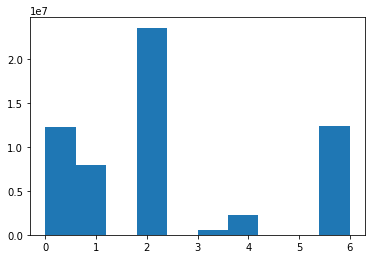

In [40]:
plt.hist(setting_temporal_network.ep['purpose'].a)

In [41]:
# PLOT AGE-SPECIFIC CONTACT MATRICES

#networks=[setting_temporal_network, graph_household]
#for label , gp in zip(['overall', 'household'], networks):
#    plot_results(label, gp)
    
#fig, (ax1,ax2)= plt.subplots(ncols=2, figsize=(2*4,4))
#ax1.plot()

In [42]:
np.unique(setting_temporal_network.ep['purpose'].a)

PropertyArray([0, 1, 2, 3, 4, 6], dtype=int32)

In [56]:
# POST-PROCESSING

def get_contacts_fast(G, purpose=None):
    
    # issue with subsestting
    
#     if purpose==None:
#         e=G.get_edges()
#         print('nb of edges: ',e.shape)
#     else:
#         e=G.get_edges()
#         e=e[G.ep['purpose'].a==purpose]
#         print('nb of edges: ',e.shape)

    e=G.get_edges()
    
    v=G.get_vertices(vprops=[G.vp['age']])

    acp=np.vstack((v[e[:,0],1],v[e[:,1],1])).T
    #twins=acp[acp[:,0]==acp[:,1]]
    #others=acp[acp[:,0]!=acp[:,1]]

    
    #return np.vstack((twins,others,others[:,[1,0]]))
    #print(acp.shape)
    return np.vstack((acp,acp[:,[1,0]]))

def plot_results(purpose, G, ax, setting, ref):
    
    size_window=6.
    precision=1
    #purpose='household'

    #fig, ax=plt.subplots(figsize=(size_window,size_window), tight_layout=True)

    age_bins=np.arange(120/precision+1)*precision
    cmap = mpl.cm.get_cmap('RdYlBu_r').copy()
    cmap.set_bad(color='white', alpha=0.1)

    df_ascm=get_contacts_fast(G, purpose=purpose)
    pp=ax.hist2d(df_ascm[:,0],df_ascm[:,1], bins=age_bins, cmap=cmap, norm=mpl.colors.LogNorm(vmin=1))

    
    if setting==None:
        ax.set_title('Default', fontsize='large')
    else:
        ax.set_title(setting, fontsize='large')
    
    if ref in [0, 3]:
        ax.set_ylabel('Age of contact', fontsize='large')
    
    if ref in [3, 4, 6]:
        ax.set_xlabel('Age', fontsize='large')
        
    if ref==None:
        ax.set_ylabel('Age of contact', fontsize='large')
        ax.set_xlabel('Age', fontsize='large')
    
    ax.set_aspect('equal')
    #ax.set_title('{} layer'.format(purpose), fontsize='xx-large')
    
    cbar=fig.colorbar(pp[3], ax=ax, shrink=.6, extend='both')
    
    
    if ref in [2]:
        cbar.set_label('Frequency of contacts',fontsize='large',rotation=270, va='bottom')
    
    #fig.savefig('files/{}_weekday.pdf'.format(purpose), bbox_inches='tight')
    #fig.savefig('files/validation_4.jpg'.format(purpose), bbox_inches='tight', dpi=400)
    #plt.show()

In [30]:
from numba.typed import Dict
from numba.core import types

link = Dict.empty(
    key_type=types.int64,
    value_type=types.int32,
)

f=np.asarray(np.unique(setting_temporal_network.vp['insee'].a))
g=np.arange(len(f))
#link=dict()

for key, value in zip(f,g):
    link[key]=value

/usr/lib/python3.9/site-packages/numba/typed/typeddict.py:33: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  d[key] = value


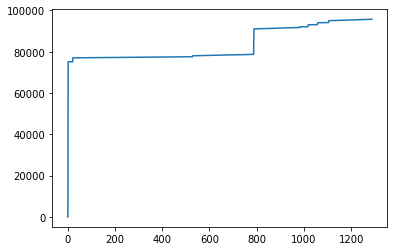

In [31]:
plt.plot(f)

In [32]:
@njit
def update_table(edges, table, link, pm):
    for edge in edges:
        u=edge[0]
        v=edge[1]
        
        u=pm[u]
        v=pm[v]
        
        if (u in link) and (v in link):
            x=link[u]
            y=link[v]

            table[x, y]+=1
    return table
    


spatial_dist=np.zeros((7, len(f), len(f)))
pm=np.asarray(setting_temporal_network.vp['insee'].a)
#edges=setting_temporal_network.get_edges()


for k in range(7):
    if k!=5:
        fn=(setting_temporal_network.ep['purpose'].a==k)
        edges=setting_temporal_network.get_edges()[fn]

        spatial_dist[k,:,:]=update_table(edges, spatial_dist[k,:,:], link, pm)
        #spatial_dist[k,:,:]=update_table(edges[:,[1,0]], spatial_dist[k,:,:], link, pm)
        print(k)

0
1
2
3
4
6


In [99]:
np.unique(setting_temporal_network.ep['purpose'].a, return_counts=True)

(PropertyArray([0, 1, 2, 3, 4, 6], dtype=int32),
 array([12459347,  7972095, 23206473,   493271,  2277133, 12388655]))

In [100]:
spatial_dist[3,:,:].sum()

493271.0

In [29]:
spatial_dist_work=np.zeros((len(f), len(f)))

fn=setting_temporal_network.ep['purpose'].a==4

edges=setting_temporal_network.get_edges()[fn]

spatial_dist_work=update_table(edges, spatial_dist_work, link, pm)
spatial_dist_work=update_table(edges[:,[1,0]], spatial_dist_work, link, pm)

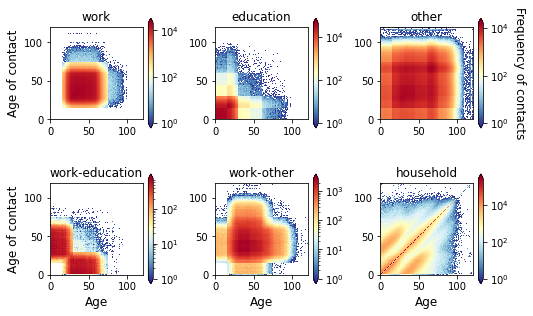

In [61]:
# plot_results(None, graph_household)

nrows=2
ncols=3

#fig, axs=plt.subplots(nrows=nrows, ncols=ncols, tight_layout=True, figsize=(3*ncols, 3*nrows))

scale=1.25
axd = plt.figure(constrained_layout=False, tight_layout=True, figsize=(6*scale, 4*scale)).subplot_mosaic(
    """
    AABBCC
    DDEEFF
    """
)

#fig = plt.gcf()
#print(fig.get_size_inches()) # size in pixels

settings=['work', 'education', 'other', 'work-education', 'work-other', 'household']
fig.subplots_adjust(wspace=0.4)

for i, purpose, setting in zip(axd, [0, 1, 2, 3, 4, 6], settings):
    plot_results(None, GraphView(setting_temporal_network, efilt=(setting_temporal_network.ep['purpose'].a ==purpose)), axd[i], setting, purpose)
    #break
    
plt.savefig('paper/contact_patterns.jpg', bbox_inches='tight', dpi=400)




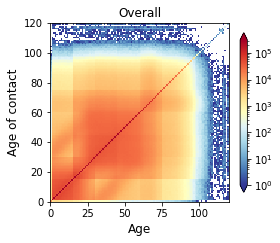

In [62]:
scale=1.
fig, ax=plt.subplots(tight_layout=True, figsize=(4*scale, 4*scale))
plot_results(None, setting_temporal_network, ax, 'Overall', None)

fig.savefig('paper/overall.jpg', bbox_inches='tight', dpi=400)


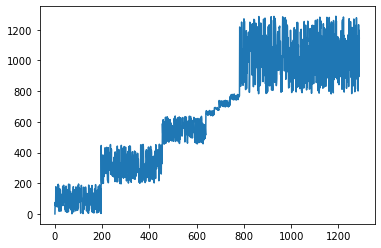

In [33]:
arr_eq=[]
arr=np.asarray([int(str(k)[:2]) for k in f])
for k in arr:
    if k==0:
        arr_eq.append(0)
    elif k==77:
        arr_eq.append(8)
    elif k==93:
        arr_eq.append(7)
    elif k==94:
        arr_eq.append(6)
    elif k==75:
        arr_eq.append(5)
    elif k==92:
        arr_eq.append(4)
    elif k==95:
        arr_eq.append(3)
    elif k==78:
        arr_eq.append(2)
    else: # 91
        arr_eq.append(1)
arr_eq=np.asarray(arr_eq)
arr_eq

idxs=np.argsort(arr_eq)
arr_eqs=arr_eq[idxs]
initial_array=spatial_dist.sum(axis=0)[idxs,:][:,idxs]
reorder=np.arange(initial_array.shape[0])
marginal=initial_array.sum(axis=0)

for k in np.unique(arr_eq):
    #reorder[arr_eq==k]=reorder[arr_eq==k][np.argsort(marginal[arr_eq==k])]
    reorder[arr_eqs==k]=reorder[arr_eqs==k][np.argsort(marginal[arr_eqs==k])]

#reorder=reorder
plt.plot(reorder)

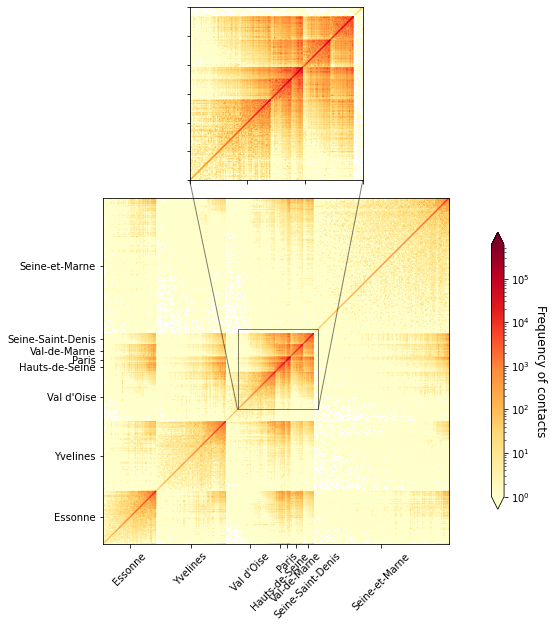

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

scale=2.
fig, ax=plt.subplots(tight_layout=True, figsize=(6*scale, 4*scale))



#for k, a in zip([0, 1, 2, 3, 4, 6], ax):
#    p1=a.imshow(spatial_dist[k,:,:], cmap='OrRd', origin='lower', norm=mpl.colors.LogNorm(vmin=1))
    
    #cbar=fig.colorbar(p1, ax=ax, shrink=.6, extend='both')
    #cbar.set_label('Frequency of contacts',fontsize='large',rotation=270, va='bottom')
    #ax.axis('off')

#ax.set_xlabel('INSEE commune', fontsize='x-large')
#ax.set_ylabel('INSEE commune', fontsize='x-large')


#idx=np.argsort(spatial_dist.sum(axis=0).sum(axis=0))
idxs=np.argsort(arr_eq)

p1=ax.imshow(initial_array[reorder,:][:, reorder], cmap='YlOrRd', origin='lower', norm=mpl.colors.LogNorm(vmin=1))
#p1=ax.imshow(ssd_new, cmap='OrRd', origin='lower', norm=mpl.colors.LogNorm(vmin=1))
#p1=ax.imshow(spatial_dist[6,:,:], cmap='OrRd', origin='lower', norm=mpl.colors.LogNorm(vmin=1))

offset=np.unique(arr_eq, return_counts=True)[1][1:]/2
ax.set_xticks(offset+np.where(np.diff(arr_eq[idxs]))[0]+1)
ax.set_xticklabels(['Essonne', 'Yvelines', "Val d'Oise", 'Hauts-de-Seine', 'Paris', 'Val-de-Marne','Seine-Saint-Denis','Seine-et-Marne'],rotation=45)

ax.set_yticks(offset+np.where(np.diff(arr_eq[idxs]))[0]+1)
ax.set_yticklabels(['Essonne', 'Yvelines', "Val d'Oise", 'Hauts-de-Seine', 'Paris', 'Val-de-Marne','Seine-Saint-Denis','Seine-et-Marne'],rotation=0)


cbar=fig.colorbar(p1, ax=ax, shrink=.8, extend='both', pad=.1/2)
cbar.set_label('Frequency of contacts',fontsize='large',rotation=270, va='bottom')

# # create new axes on the right and on the top of the current axes
# divider = make_axes_locatable(ax)
# # below height and pad are in inches
# ax_histx = divider.append_axes("top", 1.25, pad=0.1, sharex=ax)
# ax_histx.xaxis.set_tick_params(labelbottom=False)

# ax_histx.plot(marginal[reorder], lw=1.)
# # ax_histx.plot([int(str(k)[:2]) for k in f], lw=1.)
# # ax_histx.set_ylim(70, 100)
# ax_histx.grid(True, lw=0.1)
# # ax_histx.set_ylabel('Department')

# ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
# ax_histy.yaxis.set_tick_params(labelleft=False)
# ax_histy.plot(f, orientation='horizontal')

# ax.axis('off')
# ax.set_xlabel('INSEE commune', fontsize='x-large')
# ax.set_ylabel('INSEE commune', fontsize='x-large')

# inset axes....
axins = ax.inset_axes([0.25, 1.05, 0.5, 0.5])
axins.imshow(initial_array[reorder,:][:, reorder], cmap='YlOrRd', origin='lower', norm=mpl.colors.LogNorm(vmin=1))
#axins.grid(True, lw=0.1)
#ax.set_xlabel('Location size', fontsize='x-large')
#ax.set_ylabel('Density', fontsize='x-large')
#axins.set_title(r'$\log$-$\log$ scale')

# sub region of the original image
x1, x2, y1, y2 = 500, 800, 500, 800
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

fig.savefig('paper/spatial_patterns.jpg', bbox_inches='tight', dpi=400)

In [68]:
# outfile='cmatrix.npy'
# np.save(outfile, spatial_dist.sum(axis=0))

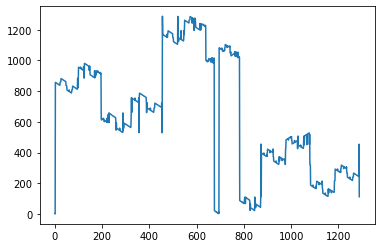

In [69]:
plt.plot(idxs)

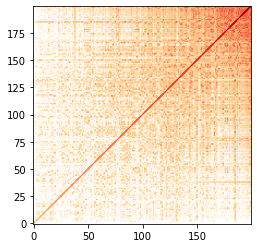

In [70]:
dd=np.argsort(spatial_dist.sum(axis=0)[:,idxs][idxs,:][0:200, 0:200].sum(axis=0))


plt.imshow(spatial_dist.sum(axis=0)[:,idxs][idxs,:][0:200, 0:200][dd,:][:,dd], cmap='OrRd', origin='lower', norm=mpl.colors.LogNorm(vmin=1))

In [32]:
ssd=spatial_dist.sum(axis=0)
ssd_new=np.zeros(ssd.shape)

In [39]:
arr=np.asarray([int(str(k)[:2]) for k in f])
infos=np.split(arr, np.where(np.diff(arr))[0]+1)



i=0
for k in [4, 3, 8, 5, 1, 6, 7, 2]:
    #pp=infos[k]
    
    np.hsplit(spatial_dist.sum(axis=0), np.where(np.diff(arr))[0]+1)[k]
    block=np.hsplit(spatial_dist.sum(axis=0), np.where(np.diff(arr))[0]+1)[k]
    ssd_new[:,i:(i+block.shape[1])]=block
    
    #i+=len(pp)
    #print(ssd[:,i:(i+len(pp))].shape)

In [27]:
u,c=np.unique(np.asarray([int(str(k)[:2]) for k in f]), return_counts=True)
print(c,u)

[  1  20 507 259 194  36  40  47 184] [ 0 75 77 78 91 92 93 94 95]


In [146]:
np.unique([int(str(k)[:2]) for k in f])

array([ 0, 75, 77, 78, 91, 92, 93, 94, 95])

In [112]:
fh=np.isin(np.asarray([int(str(k)[:2]) for k in f]), [75, 93])
fh=np.arange(len(f))[fh]
fh

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20, 1017, 1018,
       1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029,
       1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040,
       1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,
       1052, 1053, 1054, 1055, 1056])

In [82]:
spatial_dist.sum(axis=0).sum(axis=0)

array([ 11839., 146247., 154494., ..., 257098.,    304.,    814.])

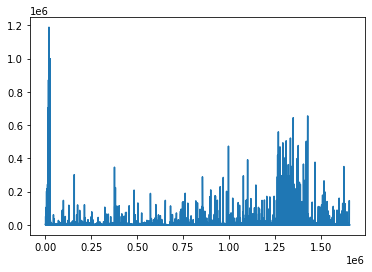

In [52]:
plt.plot(spatial_dist.sum(axis=0).reshape(-1))

In [35]:
spatial_dist.shape

(7, 1288, 1288)

In [50]:
fig = plt.gcf()
print(fig.get_size_inches()) # size in pixels

[6. 4.]


<Figure size 432x288 with 0 Axes>

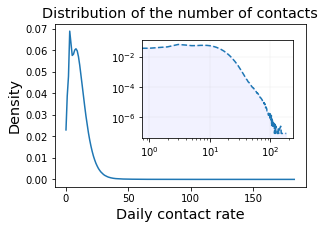

In [35]:
## OTHER RESULTS

#setting_temporal_network.get_total_degrees(setting_temporal_network.get_vertices())

u,c=np.unique(setting_temporal_network.get_total_degrees(setting_temporal_network.get_vertices()), return_counts=True)

fig, ax=plt.subplots(figsize=(4.5,3))
ax.plot(u,c/c.sum(), '-',alpha=1.) # mec='k', mew=0.5, lw=0.2
ax.set_xlabel('Daily contact rate', fontsize='x-large')
ax.set_ylabel('Density', fontsize='x-large')
#ax.grid(True, lw=0.1)
ax.set_title('Distribution of the number of contacts', fontsize='x-large')


#ax.set_xticks(u)
#ax.set_xticklabels(u,fontsize='x-large')

# inset axes....
axins = ax.inset_axes([0.35, 0.3, 0.6, 0.6])
axins.loglog(u,c/c.sum(),'--') # mec='k', mew=0.5, lw=0.2
axins.grid(True, lw=0.1)
#ax.set_xlabel('Location size', fontsize='x-large')
#ax.set_ylabel('Density', fontsize='x-large')
#axins.set_title(r'$\log$-$\log$ scale')

axins.fill_between(u, c/c.sum(), 0,
                 facecolor='orange', # The fill color
                 color='blue',       # The outline color
                 alpha=0.1/2)          # Transparency of the fill


# sub region of the original image
#x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])
#ax.indicate_inset_zoom(axins, edgecolor="black")
#fig.savefig('dnc.pdf', bbox_inches='tight')
fig.savefig('paper/dnc.jpg', bbox_inches='tight', dpi=400)
plt.show()

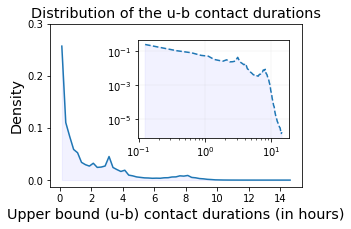

In [36]:
f=setting_temporal_network.ep['purpose'].a!=6
n=4
bins=np.arange(n*15)/n
a,b =np.histogram(setting_temporal_network.ep['duration'].a[f]/3600, bins)

fig, ax=plt.subplots(figsize=(4.5,3))
ax.plot((b[1:]+b[:-1])/2, a/a.sum(), '-') # mec='k', mew=0.5, lw=0.2
ax.fill_between((b[1:]+b[:-1])/2, a/a.sum(),0,facecolor="orange",color='blue',alpha=0.1/2)
ax.set_xlabel('Upper bound (u-b) contact durations (in hours)', fontsize='x-large')
ax.set_ylabel('Density', fontsize='x-large')
#ax.grid(True, lw=0.1)
ax.set_title('Distribution of the u-b contact durations', fontsize='x-large')

ax.set_yticks([0, 0.1, 0.2, 0.3])

# inset axes....
axins = ax.inset_axes([0.35, 0.3, 0.6, 0.6])
axins.loglog((b[1:]+b[:-1])/2, a/a.sum(),'--') # mec='k', mew=0.5, lw=0.2
axins.grid(True, lw=0.1)
#ax.set_xlabel('Location size', fontsize='x-large')
#ax.set_ylabel('Density', fontsize='x-large')
#axins.set_title(r'$\log$-$\log$ scale')

axins.fill_between((b[1:]+b[:-1])/2, a/a.sum(), 0,
                 facecolor='orange', # The fill color
                 color='blue',       # The outline color
                 alpha=0.1/2)          # Transparency of the fill


#fig.savefig('cdall.pdf', bbox_inches='tight')
#fig.savefig('cdall.jpg', bbox_inches='tight', dpi=400)

fig.savefig('paper/dubc.jpg', bbox_inches='tight', dpi=400)
plt.show()

In [53]:
#ref_graph=load_graph('files/graphs/reference_graph.xml.gz')

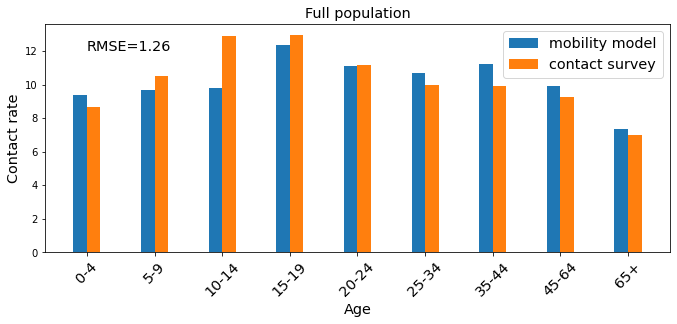

In [28]:
def get_rmse(pred, obs):
    return np.round(np.sqrt(((pred-obs)**2).sum()/len(pred)),2)

# get id's of persons conditioned on age

mnrc=[]

for u,v in zip([0, 5, 10, 15, 20, 25, 35, 45, 65], [5, 10, 15, 20, 25, 35, 45, 65, 120]):
    f=np.asarray((setting_temporal_network.vp['age'].a>=u)&(setting_temporal_network.vp['age'].a<v))
    f=setting_temporal_network.get_vertices()[f]
    #print('{}-{} - {}'.format(u,v, 1*np.round(graph_overall.get_total_degrees(f).mean(), 2)))
    mnrc.append(np.round(setting_temporal_network.get_total_degrees(f).mean(), 2))

size=1.4
fig, ax=plt.subplots(figsize=(8.*size,3.*size))


n=0
data=np.array([8.64, 10.5, 12.92, 12.96, 11.14, 9.95, 9.93, 9.24, 7.01])
#data=data/data[n]

std=np.asarray(mnrc)
#std=std/std[n]


width=0.2
ax.bar(np.arange(len(mnrc))- width/2, std, width=width, label='mobility model')
ax.bar(np.arange(len(mnrc))+ width/2, data, width=width, label='contact survey')
ax.legend(fontsize='x-large', loc='upper right', frameon=True)
#ax.grid(True, lw=0.1)
#ax.set_yticks(np.arange(4)/2)
ax.set_xlabel('Age',fontsize='x-large')
ax.set_ylabel('Contact rate',fontsize='x-large')
ax.set_xticks(np.arange(9))
ax.set_xticklabels(['0-4', '5-9', '10-14', '15-19', '20-24', '25-34', '35-44', '45-64', '65+'], rotation=45, fontsize='x-large')
# ax.axhline(y=10., color='red', lw=0.1)
ax.set_title('Full population', fontsize='x-large')
ax.text(0, 12, 'RMSE='+ str(get_rmse(std, data)), fontsize='x-large')

#fig.savefig('files/graphs/contacts_by_age-ref-2.jpg', bbox_inches='tight', dpi=300)
fig.savefig('paper/validation_{}.jpg'.format(1), bbox_inches='tight', dpi=300)

plt.show()

In [81]:
# copy results

# pd.DataFrame({'age': setting_temporal_network.vp['age'].a, 'contacts' : setting_temporal_network.get_total_degrees(setting_temporal_network.get_vertices())}).to_csv('resultsA.csv')

In [82]:
2*setting_temporal_network.num_edges()/setting_temporal_network.num_vertices()

10.000791599991292

In [37]:
# Observed age distributions (INSEE)


# inputs
year='2015'
df = pd.read_excel('data/estim-pop-nreg-sexe-aq-1975-2021.xlsx', sheet_name=year)

table=pd.read_csv('data/sheet1.csv',';')
labels=table.columns[1:].values


for k in labels:
    table[k]=table[k].str.replace(',','.').astype(float)

table=table.drop(['Index'], axis=1)

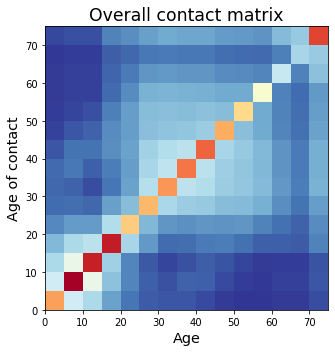

In [38]:
k=5
#bins=np.arange(100/k+1)*k

bins=np.arange(70/k+1)*k
bins=np.hstack((bins, 999))

cctc=get_contacts_fast_2(setting_temporal_network)

cmap = mpl.cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad(color='white', alpha=0.1)

size_window=5.
fig, ax=plt.subplots(figsize=(size_window,size_window), tight_layout=True)
pp=ax.hist2d(cctc[:,0],cctc[:,1], bins=bins, cmap=cmap)#, norm=mpl.colors.LogNorm(vmin=1))
    
ax.set_xlabel('Age', fontsize='x-large')
ax.set_ylabel('Age of contact', fontsize='x-large')
ax.set_aspect('equal')
ax.set_title('{}'.format('Overall contact matrix'), fontsize='xx-large')

ax.set_xlim(0,75)
ax.set_ylim(0,75)

#cbar=fig.colorbar(pp[3], ax=ax, shrink=.75)
#cbar.set_label('Frequency of contacts',fontsize='x-large',rotation=270, va='bottom')

#fig.savefig('outputs/ocontact_matrix_{}.pdf'.format('idf'), bbox_inches='tight')

overall_contact_matrix=pp[0].copy()

plt.show()

In [59]:
# (np.tril(overall_potential_network, k=-1).T+np.triu(overall_potential_network, k=0))[:3,2:].sum(axis=1)

In [40]:
def get_symmetric_matrix(A):
    #A=np.array([[1,2,3], [4, 5, 6], [7, 8, 9]])
    B=np.tril(A, k=-1).T+2*np.triu(A, k=0)-np.triu(A, k=1)
    return np.triu(B, k=1).T+B

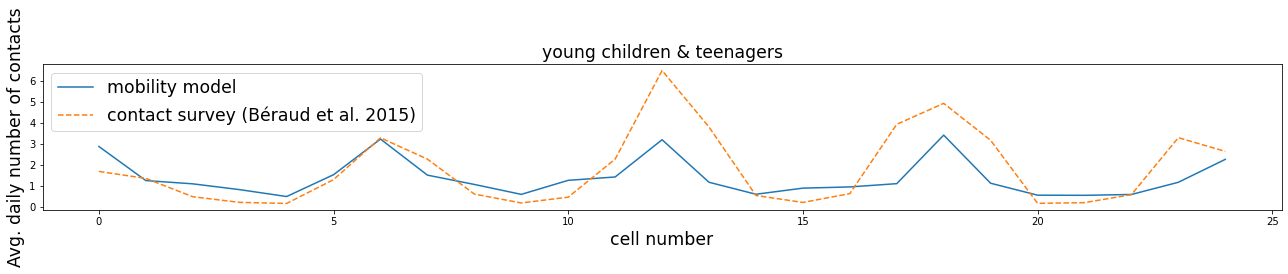

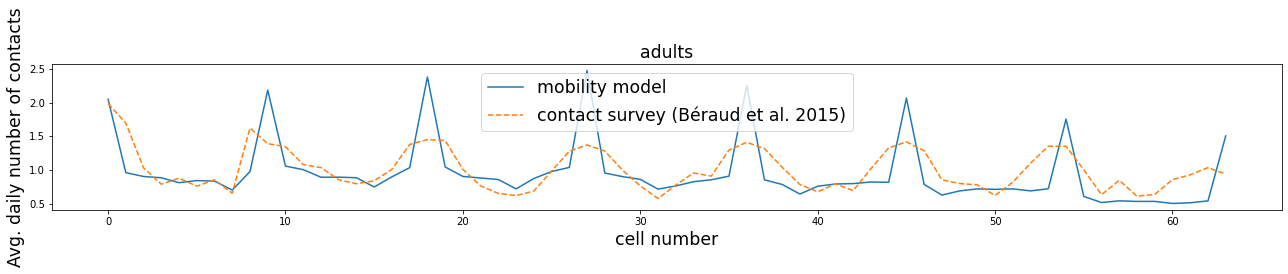

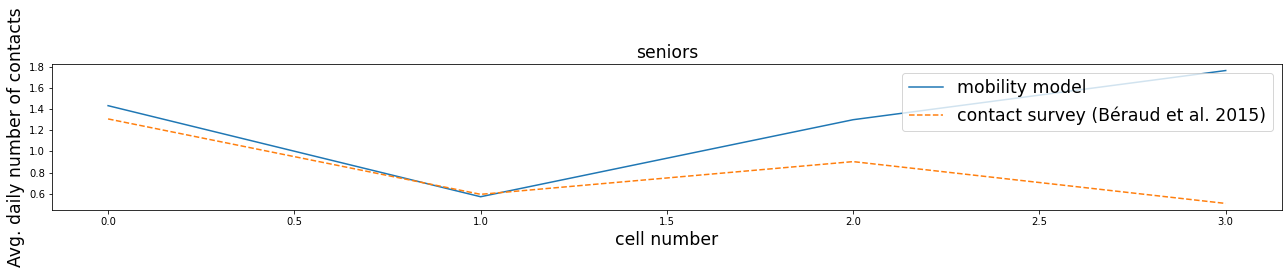

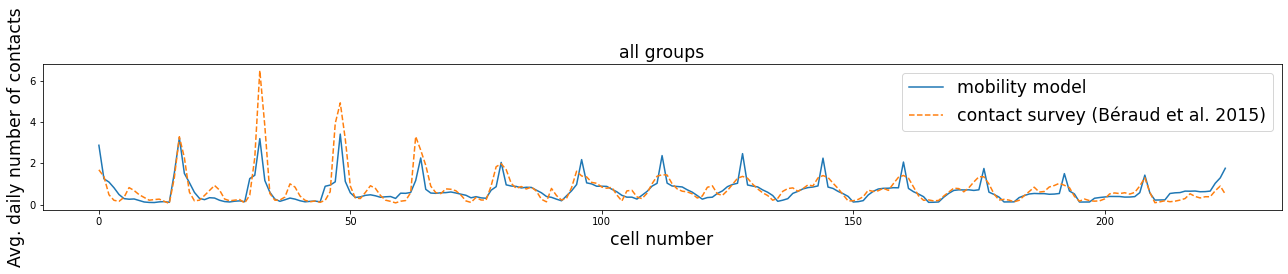

In [41]:
# 
labels=df.iloc[3,1:21].values
counts=df.iloc[17,1:21].values # 17-FR, 11-IDF
dffp=pd.DataFrame({'age': labels, 'freq': counts})


# Estimated age mobility model (EQASIM)
# df_persons=pd.read_csv('data/persons.csv',';')

pscale=1.
k=5
bins=np.arange(70/k+1)*k
bins=np.hstack((bins, 999))
agg_mm_age, b=np.histogram(df_persons['age'].values, bins)

# mobility model
Z=get_symmetric_matrix(pp[0]).copy()
ffx=np.where(agg_mm_age>0)

Z[:,ffx]=Z[:,ffx]/agg_mm_age[None,ffx]


#Z=Z/get_pop_matrix(agg_mm_age)

Z1=Z
#Z1=Z1[0:15, 0:15]


# contact survey
survey_mat=table.values
marginal=dffp['freq'].values[None, 0:survey_mat.shape[0]]
#marginal[0][-1]=dffp['freq'].iloc[14:].sum()

survey_mat_nzd=survey_mat*marginal #[0:15][None,0:15]

#survey_mat_nzd=survey_mat*get_pop_matrix(dffp['freq'].values[0:15])
Z2=survey_mat_nzd.astype(float)


for lb, up, lbb in zip([0,5,13,0], [5,13,15,15], ['young children & teenagers','adults','seniors', 'all groups']):
    ##
    scale=1

    s=4.5
    fig, ax=plt.subplots(figsize=(4*s,.7*s), tight_layout=True)
    
    ax.plot(Z1[lb:up, lb:up].reshape(-1),'-',label='mobility model')
    ax.plot(Z2[lb:up, lb:up].reshape(-1), '--',label='contact survey (Béraud et al. 2015)')
    ax.legend(fontsize='xx-large', loc='best')
    # ax.grid(True, lw=0.1)
    ax.set_xlabel('cell number', fontsize='xx-large')
    ax.set_ylabel('Avg. daily number of contacts', fontsize='xx-large')
    ax.set_title(lbb, fontsize='xx-large')

    font = {'family': 'calibri',
            'color':  'k',
            'weight': 'normal',
            'size': 20,
            }
    #ax.text(80, 6, r'$\rho$ = 0.76 (p < 0.001)', fontdict=font)
    #fig.savefig('outputs/validation_{}.pdf'.format(lbb), bbox_inches='tight')

    #fig.savefig('files/validation_{}.jpg'.format(lbb), bbox_inches='tight', dpi=300)
plt.show()

(-0.5, 14.5, -0.5, 14.5)

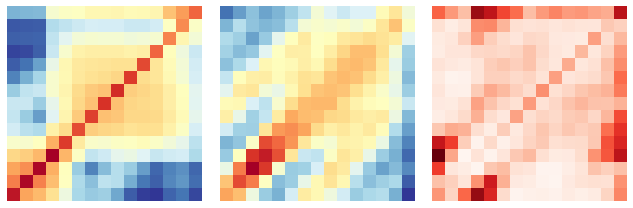

In [42]:
size_window=1.
fig, (ax1, ax2, ax3)=plt.subplots(figsize=(9*size_window,3*size_window), tight_layout=True, ncols=3)

ax1.imshow(np.log(Z1), origin='lower', cmap=cmap)
ax2.imshow(np.log(Z2), origin='lower', cmap=cmap)
ax3.imshow((Z1-Z2)/Z2*100, origin='lower', cmap='Reds')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

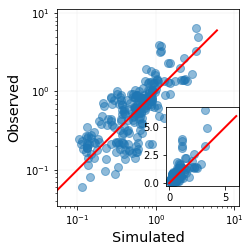

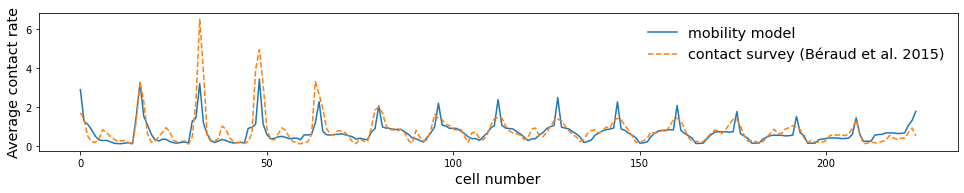

In [43]:
scale=1.2
fig, ax=plt.subplots(figsize=(3*scale, 3*scale), tight_layout=True)

ax.loglog(Z1.reshape((-1,)), 
          Z2.reshape((-1,)),'o',  
          alpha=.5, ms=8)
         # ms=7.5, mec='k', mew=0.5, lw=0.2)

ax.loglog([0,6],[0,6], color='r', lw=2.)
ax.grid(True, lw=0.1)
ax.set_xlabel('Simulated', fontsize='x-large')
ax.set_ylabel('Observed', fontsize='x-large')
#ax.set_title('Contact rates between five year age-groups i and j\n (log scale)', fontsize='x-large')
ax.axis('equal')

# bx.plot(Z1.reshape(-1),Z2.reshape(-1),'o',ms=7.5,alpha=1., mec='k', mew=0.5, lw=.2)

# # bx.set_title('(Linear scale)', fontsize='x-large')

# bx.plot([0,6],[0,6], color='r', lw=2.)
# bx.grid(True, lw=0.1)
# bx.set_xlabel('Simulated', fontsize='x-large')
# bx.set_ylabel('Observed', fontsize='x-large')
# bx.set_xticks([0, 3.5, 7])
# bx.set_yticks([0, 3.5, 7])

reduce=0.8
axins = ax.inset_axes([1-0.5*reduce, 0.1, 0.5*reduce, 0.5*reduce])
axins.plot(Z1.reshape(-1),Z2.reshape(-1),'o', alpha=0.5, ms=8)#, ms=7.5,alpha=1., mec='k', mew=0.5, lw=.2)
axins.plot([0,6],[0,6], color='r', lw=2.)
axins.axis('equal')




fig.savefig('paper/validation_{}.jpg'.format('A'), bbox_inches='tight', dpi=300)



s=0.9
fig, ax=plt.subplots(figsize=(15*s,3*s), tight_layout=True)
lb=0
ub=15
lbb=''

ax.plot(Z1[lb:up, lb:up].reshape(-1),'-',label='mobility model')
ax.plot(Z2[lb:up, lb:up].reshape(-1), '--',label='contact survey (Béraud et al. 2015)')
ax.legend(fontsize='x-large', loc='best', frameon=False)
# ax.grid(True, lw=0.1)
ax.set_xlabel('cell number', fontsize='x-large')
ax.set_ylabel('Average contact rate', fontsize='x-large')
ax.set_title(lbb, fontsize='x-large')

fig.savefig('paper/validation_{}.jpg'.format('B'), bbox_inches='tight', dpi=300)


In [44]:
setting_temporal_network.save("files/graphs/contact_network_22_8_2022.xml.gz")